In [1]:
import time, os
import re
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [2]:
with open('BG_full_dict.pickle','rb') as read_file:
    BG_data_dict = pickle.load(read_file)

In [3]:
len(BG_data_dict)

686

In [4]:
BG_df = pd.DataFrame.from_dict(BG_data_dict, orient = 'index')

In [5]:
BG_df = BG_df.reset_index()

Now I'll make dummy variables out of my 3 categorical lists.

In [6]:
categories_df = pd.get_dummies(pd.DataFrame(BG_df.categories.values.tolist()))
mechanics_df = pd.get_dummies(pd.DataFrame(BG_df.mechanics.values.tolist()))
subdomains_df = pd.get_dummies(pd.DataFrame(BG_df.subdomains.values.tolist()))

That split the columns and gave each split an enumerated name. Let's recombine them as one purely alphabetic string.

In [7]:
categories_df.columns = categories_df.columns.str[2:]
mechanics_df.columns = mechanics_df.columns.str[2:]
subdomains_df.columns = subdomains_df.columns.str[2:]

In [8]:
category_columns_list = list(categories_df.columns)
mechanics_columns_list = list(mechanics_df.columns)
subdomains_columns_list = list(subdomains_df.columns)

In [9]:
def alphanumerizer(col_list):    
    
    newcolumns = []
    for column in col_list:
        output = re.sub('[\W_]+', '', column)
        newcolumns.append(output)
    return newcolumns

In [10]:
new_categ_col_list = alphanumerizer(category_columns_list)
new_mechs_col_list = alphanumerizer(mechanics_columns_list)
new_subdoms_col_list = alphanumerizer(subdomains_columns_list)

In [11]:
categories_df.columns = new_categ_col_list
mechanics_df.columns = new_mechs_col_list
subdomains_df.columns = new_subdoms_col_list

Just way too many categories as well as too many mechanics. I'm dropping categories completely and seriously trimming down mechanics. I'm dropping "children's games" and "family games" from subdomains because they seem like uninteresting predictors of my target variable (of course children's games and family games will tend towards low complexity, perhaps with some exceptions for the latter subdomain). I'm also dropping "customizable games" because only 15 games in my sample qualify for that subdomain.

In [12]:
#categories_df = categories_df.groupby(level=0, axis=1).sum()
mechanics_df = mechanics_df.groupby(level=0, axis=1).sum()
mechanics_df = mechanics_df[mechanics_df.columns[mechanics_df.sum() >= 60]]

subdomains_df = subdomains_df.groupby(level=0, axis=1).sum()
subdomains_df = subdomains_df.drop(['ChildrensGames', 'FamilyGames', 'CustomizableGames'], axis=1)

If I only look at mechanics found in 60 or more games from my sample, that trims this set down to 9 features.

And actually, instead of individually looking at the #s of categories, mechanics, and subdomains, I'm just going to look at # of mechanics.

In [13]:
#categories_df['index'] = BG_df['index']
mechanics_df['index'] = BG_df['index']
subdomains_df['index'] = BG_df['index']

In [14]:
BG_df = (pd.concat([BG_df, mechanics_df, subdomains_df], axis=1)
         .drop(['mechanics', 'subdomains', 'categories'], axis=1))

In [15]:
#dropping index columns and resetting index to name
BG_df = (BG_df.loc[:,~BG_df.columns.duplicated()]
         .set_index('name')
         #also getting rid of some features that are redundant(maxtime, mintime) or uninteresting (age)
         .drop(['index', 'minplayers','maxplayers', 'maxtime', 'mintime', 'age',
                'num_subdomains', 'num_categories', 'year'], axis=1))

In [16]:
BG_df.columns

Index(['playingtime', 'num_mechanics', 'weight', 'user_rating', 'desc_wc',
       'kickstarted', 'forums', 'num_ratings', 'plays', 'page_views', 'owners',
       'CardDrafting', 'DiceRolling', 'HandManagement', 'HexagonGrid',
       'ModularBoard', 'SetCollection', 'Simulation', 'TilePlacement',
       'VariablePlayerPowers', 'AbstractGames', 'PartyGames', 'StrategyGames',
       'ThematicGames', 'Wargames'],
      dtype='object')

In [17]:
#move weight(aka complexity) to front of df for because I like it better there
complexity = BG_df['weight']
BG_df.drop(labels=['weight'], axis=1,inplace = True)
BG_df.insert(0, 'complexity', complexity)

In [18]:
BG_df = BG_df.astype('float')

In [19]:
#There are 4 games with no playing time listed, so I'm dropping those
BG_df = BG_df[BG_df['playingtime'] > 0]

In [20]:
BG_df

,complexity,playingtime,num_mechanics,user_rating,desc_wc,kickstarted,forums,num_ratings,plays,page_views,...,ModularBoard,SetCollection,Simulation,TilePlacement,VariablePlayerPowers,AbstractGames,PartyGames,StrategyGames,ThematicGames,Wargames
name,,,,,,,,,,,,,,,,,,,,,
Instinct,1.3636,20.0,2.0,5.72657,34.0,0.0,2.0,134.0,139.0,22161.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Heckmeck Barbecue,1.4815,25.0,2.0,6.24042,156.0,0.0,4.0,413.0,1023.0,29493.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Circadians: First Light,3.4861,90.0,8.0,7.81810,247.0,1.0,112.0,823.0,2304.0,103714.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
The Ravens of Thri Sahashri,3.4054,45.0,6.0,7.22181,294.0,0.0,153.0,11.0,3710.0,164254.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
The Battle of Monmouth,2.6842,180.0,4.0,6.63136,192.0,0.0,5.0,118.0,31.0,26496.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Expancity,2.0000,90.0,4.0,6.95426,106.0,0.0,46.0,564.0,1108.0,67247.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
TurfMaster,1.9681,75.0,3.0,7.23507,402.0,0.0,132.0,945.0,2444.0,133804.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Import / Export,3.2174,90.0,7.0,7.34257,131.0,1.0,128.0,645.0,2131.0,100455.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [21]:
BG_df.columns

Index(['complexity', 'playingtime', 'num_mechanics', 'user_rating', 'desc_wc',
       'kickstarted', 'forums', 'num_ratings', 'plays', 'page_views', 'owners',
       'CardDrafting', 'DiceRolling', 'HandManagement', 'HexagonGrid',
       'ModularBoard', 'SetCollection', 'Simulation', 'TilePlacement',
       'VariablePlayerPowers', 'AbstractGames', 'PartyGames', 'StrategyGames',
       'ThematicGames', 'Wargames'],
      dtype='object')

In [22]:
#split df so I can eliminate outlier rows based on applicable columns
outliers_df = (BG_df[['complexity', 'playingtime', 'user_rating', 'desc_wc', 'forums',
                      'num_ratings', 'plays', 'page_views', 'owners']].reset_index())
holdout_df = (BG_df[['num_mechanics', 'kickstarted', 'CardDrafting', 'DiceRolling', 'HandManagement', 'HexagonGrid',
                    'ModularBoard', 'SetCollection', 'Simulation', 'TilePlacement', 'VariablePlayerPowers',
                    'AbstractGames', 'PartyGames', 'StrategyGames', 'ThematicGames', 'Wargames']].reset_index())

#get rid of all entries with values more than 3 STdevs from the mean
no_outliers_df = outliers_df[(np.abs(stats.zscore(BG_df)) < 3).all(axis=1)]
#recombine with the holdout set
BG_df = pd.concat([no_outliers_df, holdout_df], axis=1).dropna(axis=0).set_index('name')

In [23]:
BG_df.columns

Index(['complexity', 'playingtime', 'user_rating', 'desc_wc', 'forums',
       'num_ratings', 'plays', 'page_views', 'owners', 'num_mechanics',
       'kickstarted', 'CardDrafting', 'DiceRolling', 'HandManagement',
       'HexagonGrid', 'ModularBoard', 'SetCollection', 'Simulation',
       'TilePlacement', 'VariablePlayerPowers', 'AbstractGames', 'PartyGames',
       'StrategyGames', 'ThematicGames', 'Wargames'],
      dtype='object')

In [24]:
#some custom features that might be more predictive
BG_df['playsperowner'] = BG_df['plays'] / BG_df['owners']
BG_df['pageviewsperplay'] = BG_df['page_views'] / BG_df['plays']

#get rid of the raw features, as well as "forums" because it seems multicolinear with page views and owners
BG_df = BG_df.drop(['plays', 'owners', 'page_views'], axis=1)

In [26]:
#pickled BG_df as BG_df.pickle here

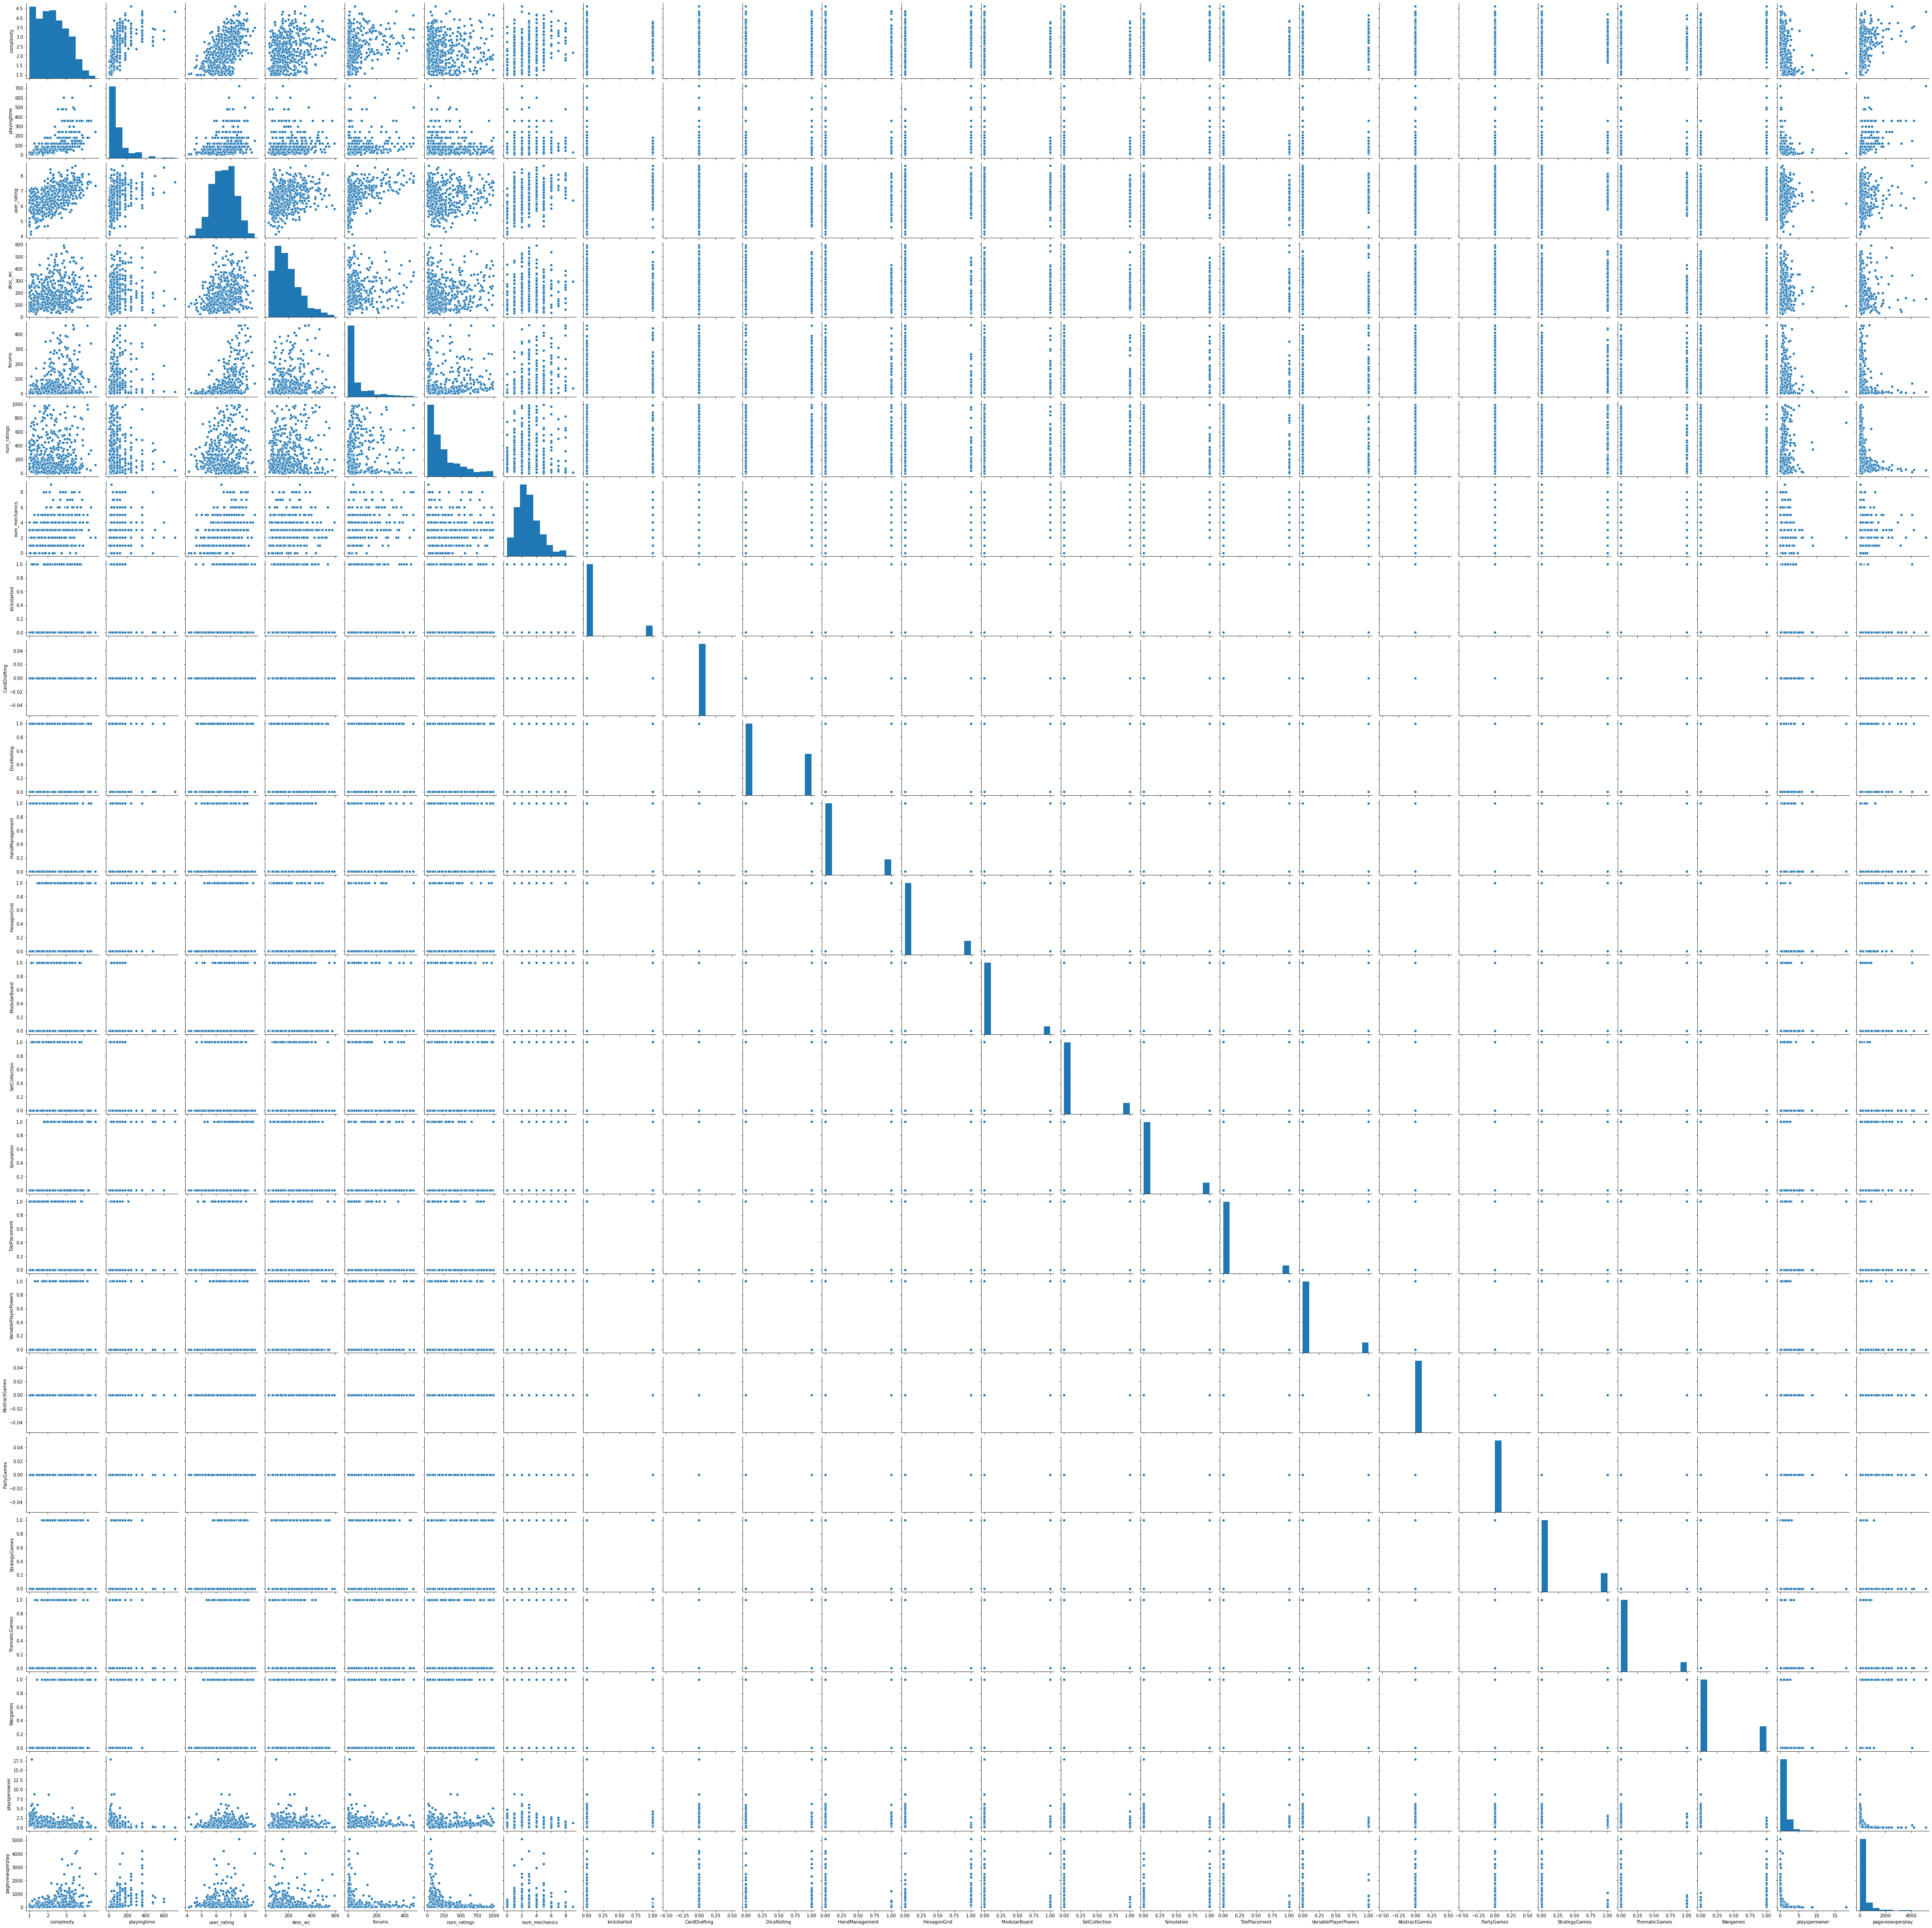

In [27]:
sns.pairplot(BG_df);

In [ ]:
sns.heatmap(BG_df.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1);

In [ ]:
X = BG_df.loc[:,['playsperowner', 'pageviewsperplay', 'playingtime', 'user_rating', 'desc_wc', 'forums',
        'num_ratings', 'num_mechanics', 'kickstarted', 'CardDrafting', 'DiceRolling', 'HandManagement',
        'HexagonGrid', 'ModularBoard', 'SetCollection', 'Simulation', 'TilePlacement', 'VariablePlayerPowers', 
        'AbstractGames', 'PartyGames', 'StrategyGames', 'ThematicGames', 'Wargames']]

y = BG_df['complexity']

In [ ]:
#Split the data 60 - 20 - 20 train/val/test

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25)

In [ ]:
X_train.columns

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
X_val.shape

(array([428.,  47.,  17.,   6.,   5.,   1.,   2.,   2.,   1.,   1.]),
 array([3.89078695e+00, 5.14818375e+02, 1.02574596e+03, 1.53667355e+03,
        2.04760114e+03, 2.55852873e+03, 3.06945631e+03, 3.58038390e+03,
        4.09131149e+03, 4.60223908e+03, 5.11316667e+03]),
 <a list of 10 Patch objects>)

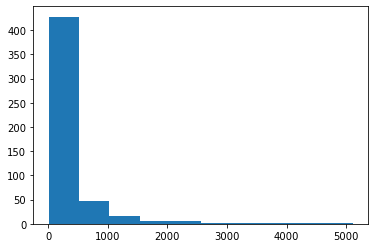

In [31]:
plt.hist(BG_df['pageviewsperplay'])